In [4]:
!pip3 install matplotlib --break-system-packages

  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl (7.8 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.3 MB/s eta 0:00:00
Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl (3.4 MB)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal

from IPython.display import Audio


In [16]:
def wavread(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  # Read in wav file.
  file_handle = open(filename, 'rb')
  samplerate, wave_data = wav.read(file_handle)
  # Normalize short ints to floats in range [-1..1).
  data = np.asarray(wave_data, dtype=np.float32) / 32768.0
  return data, samplerate

def wavwrite(data, samplerate, filename):
  """Write a waveform to a WAV file."""
  wav.write(filename, samplerate, (32768.0 * data).astype(np.int16))

def play(waveform, rate):
    int

filename = 'Piano.ff.D5.wav'
waveform, sr = wavread(filename)
print(sr, waveform.shape)
#Audio(data=waveform.T, rate=sr)

44100 (1344782, 2)


88200
(88200,)


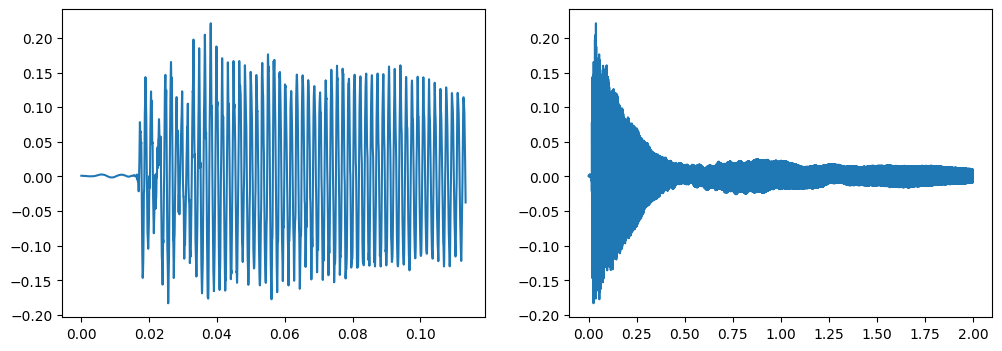

In [17]:
# Extract a segment to analyze, left channel only, dropping some initial silence
drop_initial_time = 0.42
initial_time = 2.0  # sec
print(int(round(initial_time * sr)))
d = waveform[int(round(drop_initial_time * sr)) + np.arange(int(round(initial_time * sr))), 0]
print(d.shape)
t = np.arange(len(d)) / sr
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(t[:5000], d[:5000])
plt.subplot(122)
plt.plot(t, d)

589.0862058163939


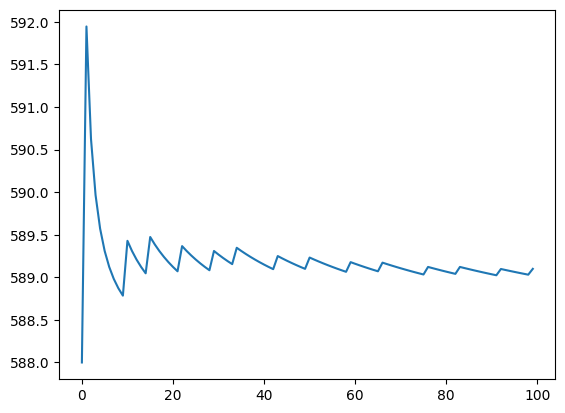

In [18]:
# Estimate fundamental by autocorrelation.
acr = np.correlate(d, d, 'full')[len(d) - 1: len(d) + 10000]
# Find 16th peak, divide by 16
maxima = scipy.signal.argrelextrema(acr, np.greater)[0]
npeaks = 100
freqs = sr * np.arange(1, npeaks + 1) / maxima[:npeaks]
plt.plot(freqs)
freq = np.mean(freqs[-40:])
print(freq)
# Nominal: D5= 587.3295

In [60]:
def lin_to_db(l):
    return 20 * np.log10(l)

def db_to_lin(d):
    return np.pow(10.0, d / 20.0)

In [20]:
def heterodyne_extract(waveform, fundamental_freq, harmonic_number=1.0, sr=44100, smooth_cycles=2.0):
    """Return a full-sample-rate amplitude and frequency envelope near the specified frequency."""
    t = np.arange(len(waveform)) / sr
    h_freq = harmonic_number * fundamental_freq
    complex_exp = np.exp(-1j * 2 * np.pi * h_freq * t)
    f_period = sr / (h_freq / harmonic_num)
    #print("f_period=", f_period)
    smooth_len = int(round(smooth_cycles * f_period * harmonic_number))
    #print("sm_len=", smooth_len)
    smooth_win = np.hanning(smooth_len)
    smooth_win = smooth_win / np.sum(smooth_win)
    smoothed_heterodyne_waveform = np.convolve(smooth_win, waveform * complex_exp, 'same')
    heterodyne_magnitude = np.abs(smoothed_heterodyne_waveform)
    smoothed_dphi_dt = np.diff(np.convolve(smooth_win, np.unwrap(np.angle(smoothed_heterodyne_waveform)), 'same'))
    inst_freq = h_freq + smoothed_dphi_dt / (2 * np.pi) * sr
    dphi_dt_valid = (np.abs(smoothed_dphi_dt) < 0.5)
    dphi_dt_weighting = heterodyne_magnitude[:-1] * dphi_dt_valid
    weighted_mean_dphi_dt = np.sum(dphi_dt_weighting * smoothed_dphi_dt) / np.sum(dphi_dt_weighting)   # radians / sample
    avg_freq = h_freq + weighted_mean_dphi_dt / (2 * np.pi) * sr   # cycles / second
    reconstructed_waveform = 2 * np.real(smoothed_heterodyne_waveform * np.conj(complex_exp))
    return lin_to_db(heterodyne_magnitude), inst_freq, avg_freq, reconstructed_waveform

pre_freq=589.23 post_freq=588.73 diff=-0.50


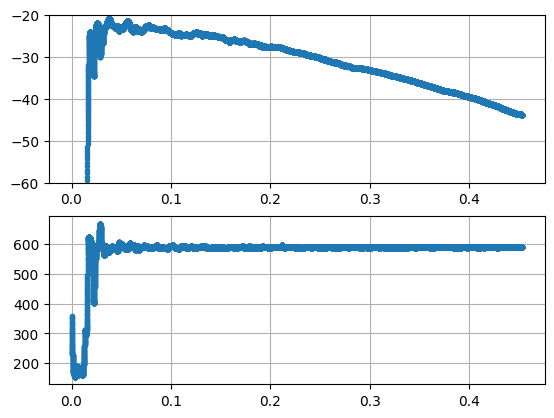

In [28]:
# Heterodyne
# h_num  delta_f
# 1      -0.63
# 2      -6.5
# 3       4.1
# 4      18.7
# 5      35.3
# 6      61.4
# 7     104     4229
# 8.2    31.4   4863
# 9.3    97.1   5518
# 10.2          6003
# 10.8          6222
# 11.2          6593
# 11.7          6890
# 13.3          7830
# 14.15         8343
# 15.45         9097
# 16.7          9845

f_freq = 589.232
harmonic_num = 1
sm_cyc = 2.0

mag, freq, avg_freq, recons_waveform = heterodyne_extract(d, f_freq, harmonic_num, sr, sm_cyc)
ii = np.arange(20000)

plt.subplot(211)
plt.plot(t[ii], mag[ii], '.')
plt.grid()
plt.ylim([-60, -20])

plt.subplot(212)
plt.plot(t[ii], freq[ii], '.')
plt.grid()

print("pre_freq=%.2f" % (f_freq * harmonic_num), "post_freq=%.2f" % avg_freq, "diff=%.2f" % (avg_freq - f_freq * harmonic_num))

589.232 588.8175952390667 589.232 588.8175952390667
589.232 589.0619462918513 1178.464 1178.1238925837026
589.232 590.8028630414327 1767.696 1772.408589124298
589.232 593.5323406524141 2356.928 2374.1293626096563
589.232 596.0564193204287 2946.16 2980.2820966021436
589.232 590.7959669322423 3535.392 3544.775801593454
589.232 587.4683964525525 4242.4704 4229.772454458378
589.232 592.8794528301485 4831.702399999999 4861.611513207217
589.232 592.4510962238674 5479.8576 5509.795194881966
589.232 587.9181204608858 6010.166399999999 5996.764828701034
589.232 588.7088477298876 6216.3976 6210.878343550315
589.232 588.8619675415677 6363.7056 6359.709249448932
589.232 588.2156482935658 6599.398399999999 6588.015260887936
589.232 588.8628020032437 6894.014399999999 6889.694783437951
589.232 588.6269936593952 7836.7856 7828.739015669958
589.232 589.6935032700576 8337.6328 8344.163071271316
589.232 588.7157862094843 9103.634399999999 9095.658896936533
589.232 589.4886266107994 9840.1744 9844.460064

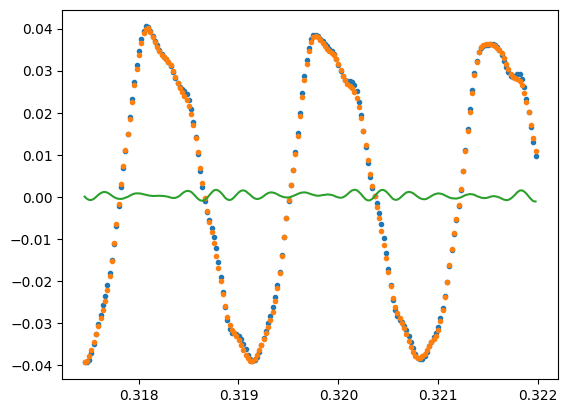

In [58]:
recons_d = np.zeros_like(d)

f_freq = 589.232
sm_cyc = 2.0

d_remaining = np.array(d)

mags = []
freqs = []

for h_num in [1, 2, 3, 4, 5, 6, 7.2, 8.2, 9.3, 10.2, 10.55, 10.8, 11.2, 11.7, 13.3, 14.15, 15.45, 16.7]:
    mag, freq, avg_freq, recons_waveform = heterodyne_extract(d_remaining, f_freq, h_num, sr, sm_cyc)
    # Repeat with estimated frequency
    print(f_freq, avg_freq / h_num, f_freq * h_num, avg_freq)
    if h_num > 8:
        mag, freq, avg_freq, recons_waveform = heterodyne_extract(d, avg_freq / h_num, h_num, sr, sm_cyc)
    recons_d += recons_waveform
    d_remaining -= recons_waveform
    mags.append(mag)
    freqs.append(freq)

mags = np.array(mags)
freqs = np.array(freqs)
print(mags.shape)

resid = d - recons_d

ii = np.arange(14000, 14200)
plt.plot(t[ii], d[ii], '.', t[ii], recons_d[ii], '.', t[ii], resid[ii])
#Audio(data=d.T, rate=sr)
#Audio(data=recons_d.T, rate=sr)
Audio(data=(resid).T, rate=sr)

In [23]:
wavwrite(resid, sr, 'resid.wav')
wavwrite(recons_d, sr, 'recons.wav')

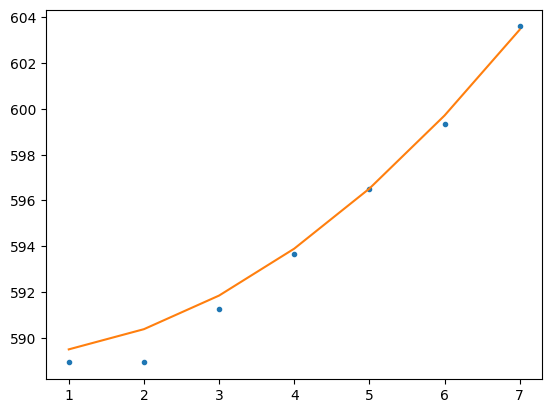

In [24]:
# 1      -0.2853
# 2      -0.6199
# 3       6.057
# 4      17.64
# 5      36.26
# 6      60.77
# 7     100.6
f_dev = [-0.28, -.62, 6.06, 17.64, 36.26, 60.77, 100.6]
xx = np.arange(1, len(f_dev) + 1)
h_freq = 589.232 * xx + f_dev
plt.plot(xx, h_freq / xx, '.', xx, 589.2 * np.sqrt(1 + .001 * xx*xx))

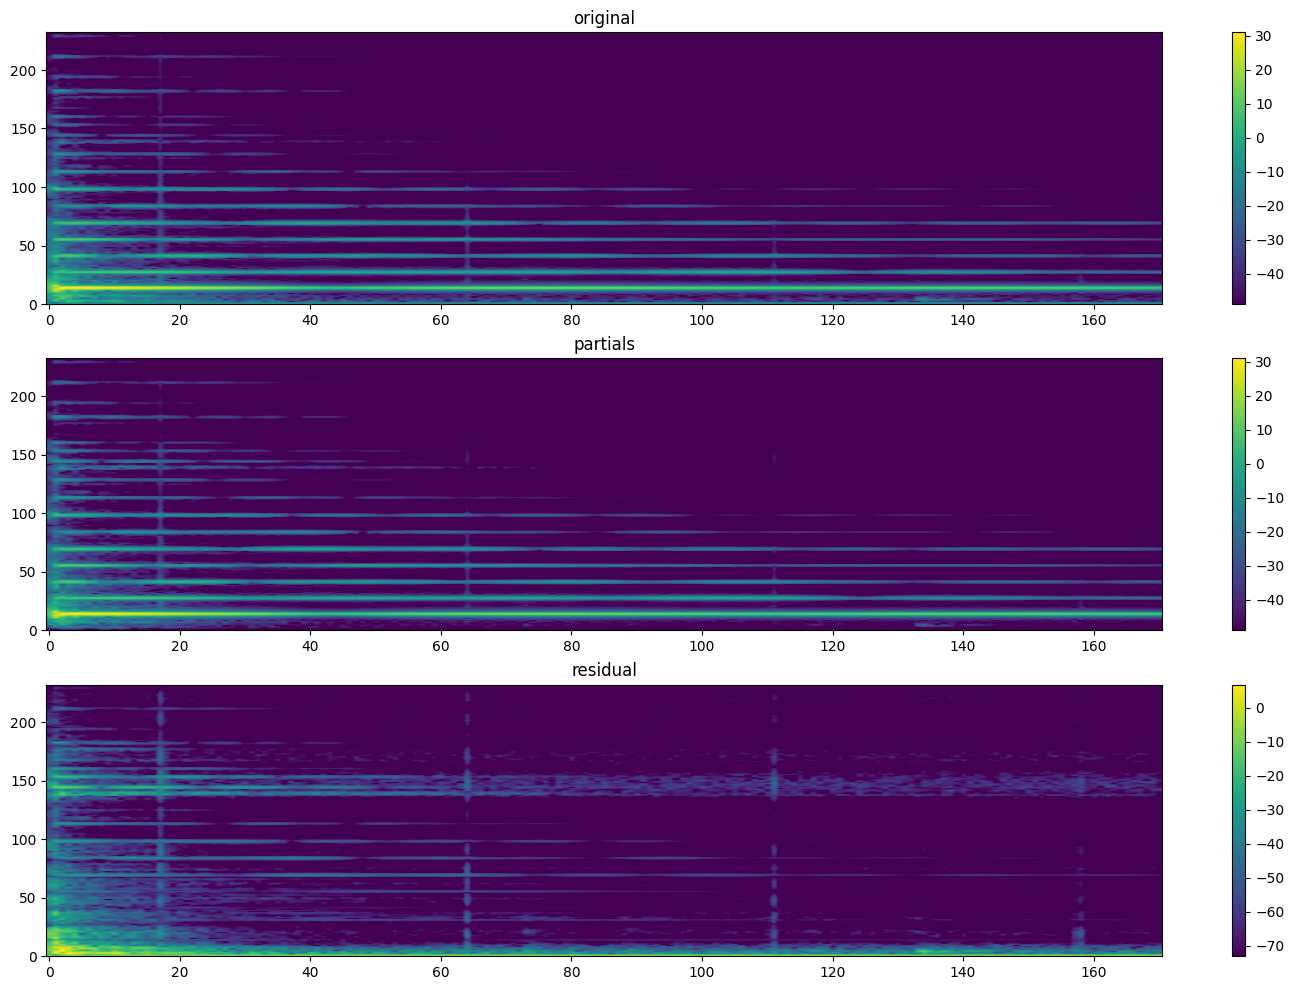

In [25]:
from scipy import fft

def spectrogram(x, fft_len=1024, win_len=None, hop_len=None, window_fn=np.hanning, sr=1, f_max=0.5, title=None):
    if win_len is None:
        win_len = fft_len
    if hop_len is None:
        hop_len = win_len // 2
    # Window.
    prepad_len = (fft_len - win_len) // 2
    win = np.hstack([np.zeros(prepad_len), window_fn(win_len), np.zeros(fft_len - win_len - prepad_len)])
    # Frame.
    frame_indices = np.arange(0, len(x) - win_len, hop_len)[:, np.newaxis] + np.arange(win_len)[np.newaxis, :]
    x_chunks_windowed = x[frame_indices] * win[np.newaxis, :]
    # Transform.
    stft_mag_db = 20 * np.log10(np.abs(fft.fft(x_chunks_windowed, n=fft_len)[:, :(fft_len // 2 + 1)]))
    num_frames, num_bins = stft_mag_db.shape
    t_base = np.arange(num_frames) * hop_len / sr
    f_base = np.arange(num_bins) * sr / 2
    plt.imshow(stft_mag_db.T, aspect='auto', origin='lower')
    plt.clim(np.max(stft_mag_db) + [-80, 0])
    plt.ylim([0, f_max / sr * fft_len])
    #plt.xticks(t_base[plt.xticks()[0].astype(int)[:-1]])
    #plt.yticks(f_base[plt.yticks()[0].astype(int)[:-1]])
    plt.colorbar()
    if title:
        plt.title(title)

plt.figure(figsize=(18, 12))
plt.subplot(311)
spectrogram(d, sr=sr, f_max=10000, title='original')
plt.subplot(312)
spectrogram(recons_d, sr=sr, f_max=10000, title='partials')
plt.subplot(313)
spectrogram(resid, sr=sr, f_max=10000, title='residual')


[np.float64(-116.00336663003343), 8, np.float64(-88.5497220449943), 16, np.float64(-90.45083611670188), 340, np.float64(-124.9981766575612), 1018, np.float64(-122.41614780429596)]


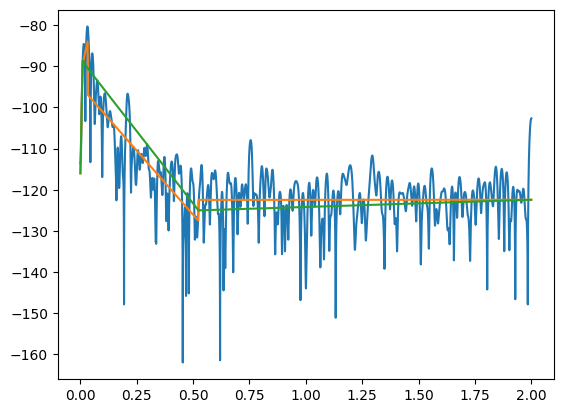

In [56]:
# Piecewise-linear fits to amplitude envelopes.
# from piano-partials.ipynb

def lin_fit(x):
    """Least-squares linear fit to points."""
    # xhat = a + b.index
    # err = x[i] - (a + b.i)
    # err^2 = x[i]^2 - 2 x[i] (a + b.i) + (a^2 + 2 a b i +b^2 i^2)
    # Define axes around midpoint.
    lenx = len(x)
    if not lenx:
        return []
    index = np.arange(lenx) - (lenx - 1) / 2
    # Make x zero mean
    a = np.mean(x)
    x_z = x - a
    b = 0
    if lenx > 1:
        # Linear fit is normalized inner product
        b = np.sum(x_z * index) / np.sum(index * index)
    return a + b * index

def fit_2_segs(x):
    """Fit x with 2 linear segments, searching all divisions."""
    # Try every poss division of remainder.
    besterr = np.sum(np.abs(x))
    besterrpt = 0
    bestxhat = []
    bestseg1 = []
    bestseg2 = []
    for divpt in np.arange(0, len(x)):
        seg1 = lin_fit(x[:divpt + 1])
        seg2 = lin_fit(x[divpt:])
        xhat = np.hstack([seg1[:-1], seg2])
        abserr = np.sum(np.abs(xhat - x))
        if abserr < besterr:
            besterr = abserr
            besterrpt = divpt
            bestseg1 = seg1
            bestseg2 = seg2
            bestxhat = xhat
    # Parameterization is [value, interval, value interval, value...]
    parameters = [bestseg1[0], len(bestseg1), 0.5 * (bestseg1[-1] + bestseg2[0]), len(bestseg2), bestseg2[-1]]
    #print(bestseg1, bestseg2, parameters)
    #print("parameters=", parameters)
    return bestxhat, parameters

def expand_params(params):
    """Convert [val, npts, val, npts, val] sequence to points."""
    val0 = params[0]
    outpts = [[val0]]
    npts_val_pairs = np.vstack([params[1::2], params[2::2]])
    for npts, val in npts_val_pairs.transpose():
        outpts.append(np.linspace(val0, val, int(npts))[1:])
        val0 = val
    return np.concatenate(outpts)
                    

def median(x):
    npts2 = (len(x) - 1) // 2
    return np.sort(x)[npts2]

def median_filter(x, npts):
    npts2 = (npts - 1) // 2
    padded_x = np.hstack([x[0] * np.ones(npts2), x, x[-1] * np.ones(npts2)])
    y = np.zeros_like(x)
    for i in range(len(x)):
        y[i] = median(padded_x[i : i + npts])
    return y

def linseg_fit(x):
    """Approximate sequence x as a set of line segments."""
    # Start with onset slope
    maxpt = np.argmax(x)
    #print("maxpt=", maxpt)
    initial, i_params = fit_2_segs(x[:maxpt + 1])
    tail, t_params = fit_2_segs(x[maxpt:])
    params = i_params[:-1] + [0.5 * (i_params[-1] + t_params[0])] + t_params[1:]
    #print(initial.shape, tail.shape)
    #print(params)
    return np.hstack([initial, tail[1:]]), expand_params(params), params

def fill_gaps(x):
    """Bridge parts of x that are nan with linear interpolation."""
    gaps = np.isnan(x)
    x_out = np.array(x)
    gap_starts = np.flatnonzero(np.logical_and(gaps, np.hstack([[1], 1 - gaps[:-1]])))
    gap_ends = np.flatnonzero(np.logical_and(1 - np.hstack([gaps, [0]]), np.hstack([[0], gaps])))
    #print(gap_starts, gap_ends)
    for gap_start, gap_end in zip(gap_starts, gap_ends):
        if gap_start == 0:
            start_val = x[gap_end]
        else:
            start_val = x[gap_start - 1]
        if gap_end == len(x):
            end_val = x[gap_start - 1]
        else:
            end_val = x[gap_end]
        fill = np.linspace(start_val, end_val, gap_end - gap_start + 2)
        print(gap_start, gap_end, start_val, end_val, fill)
        x_out[gap_start:gap_end] = fill[1:-1]
    return x_out
    
def mend_gaps(x, threshold=2, filter_len=9):
    """Interpolate portions of x that are too wide."""
    gaps = np.flatnonzero(np.isnan(x))
    x_patched = fill_gaps(x)
    smoothed = median_filter(x_patched, filter_len)
    delta = np.abs(x_patched - smoothed)
    x_patched[np.flatnonzero(delta > threshold)] = np.nan
    x_patched[gaps] = np.nan
    print("gap pts=", np.sum(np.isnan(x_patched)))
    return fill_gaps(x_patched)
    #return smoothed

f_freq = 589.232
harmonic_num = 10
sm_cyc = 2.0

mag, freq, avg_freq, recons_waveform = heterodyne_extract(d, f_freq, harmonic_num, sr, sm_cyc)

#i = np.arange(len(mag))
#plt.plot(i[:2000], mag[:2000], i[:2000:64], mag[:2000:64])

hop_len = 64

xhat, xhat2, params = linseg_fit(mag[::hop_len])

plt.plot(t, mag, t[::hop_len], xhat, t[::hop_len], xhat2)
print(params)

In [86]:
# Convert sinusoids into bp sets

harms_params = {}

max_harmonic = 18

for hnum in range(max_harmonic):
    x = mags[hnum, ::hop_len]
    x[np.flatnonzero(x == 0)] = np.nan
    xhat, xhat2, params = linseg_fit(median_filter(x, 5))
    #print(xhat.shape, xhat2.shape)
    val0 = params[0]
    nvals = zip(params[1::2], params[2::2])
    bp_list = [[0, db_to_lin(params[0])]] + [(int(round(n * dt * 1000)), lin_of_db(val)) for n, val in nvals]
    last_time, last_mag = bp_list[-1]
    last_mag_db = lin_to_db(last_mag)
    final_mag_db = -100.0
    if last_mag_db > final_mag_db:
        terminal_slope = 20.0  # -db/sec
        final_dur = (last_mag_db - final_mag_db) / terminal_slope
        bp_list.append((int(round(1000*final_dur)), db_to_lin(final_mag_db)))
    print("h", hnum + 1, bp_list)
    harms_params[hnum + 1] = bp_list
    

h 1 [[0, np.float64(1.9919400349624627e-05)], (9, np.float64(0.42732309598836465)), (39, np.float64(11.041265839817903)), (546, np.float64(0.5643077112853059)), (1412, np.float64(0.5815850519177009)), (4765, np.float64(1e-05))]
h 2 [[0, np.float64(1.4458023394143454e-05)], (17, np.float64(0.36641467816952)), (132, np.float64(0.4493492044731923)), (959, np.float64(0.1312436178280059)), (897, np.float64(0.01392342890481284)), (3144, np.float64(1e-05))]
h 3 [[0, np.float64(9.356859248857575e-06)], (16, np.float64(0.3463066908799916)), (35, np.float64(0.7950790790566625)), (87, np.float64(0.07250370294243488)), (1868, np.float64(0.007480475234730304)), (2874, np.float64(1e-05))]
h 4 [[0, np.float64(5.8636491422871465e-06)], (22, np.float64(0.23348675306577985)), (16, np.float64(0.47452350800357407)), (448, np.float64(0.03292696329270361)), (1519, np.float64(0.002955421776956385)), (2471, np.float64(1e-05))]
h 5 [[0, np.float64(2.429152132132001e-06)], (13, np.float64(0.08721396032035343)),

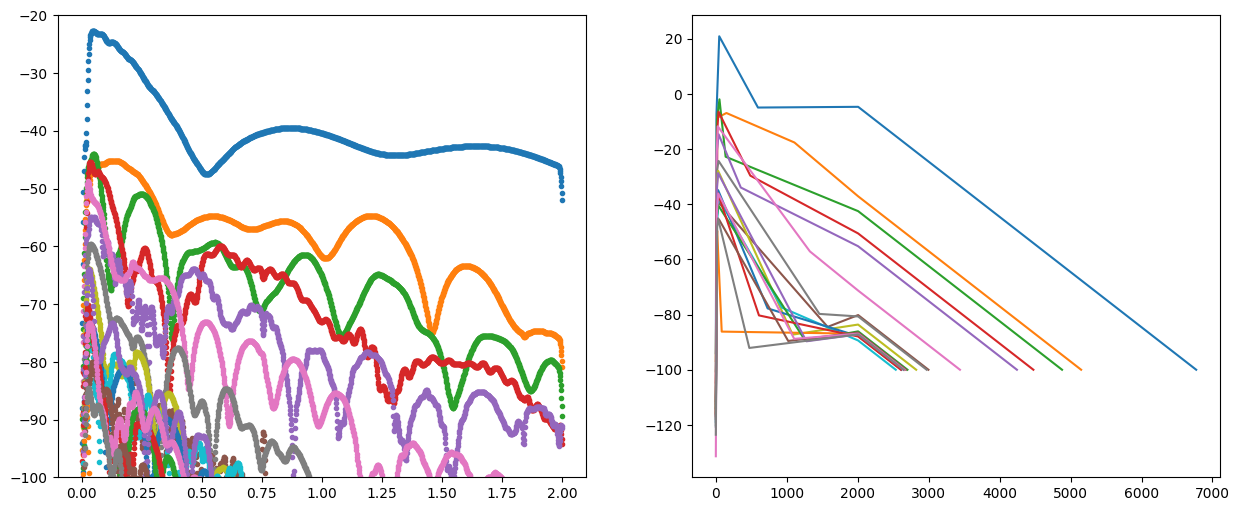

In [89]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
nfrm = mags[harms, ::hop_len].shape[-1]
harms = np.arange(len(harms_params))
frmTime = np.arange(nfrm) * hop_len / sr
_ = plt.plot(frmTime[:nfrm], mags[harms, ::hop_len].T, '.')
plt.ylim([-100, -20])

plt.subplot(1,2,2)
for i in range(len(harms_params)):
    hnum = i + 1
    times, vals = zip(*np.array(harms_params[hnum]))
    times = np.cumsum(times)
    vals = np.array(vals)
    plt.plot(times, lin_to_db(vals))

In [93]:
import json
print(filename.split('.'))
params_file = ''.join(filename.split('.', -1)[:-1]) + '.json'
print(params_file)
#with open(params_file, 'w') as f:
#    f.write(json.dumps(harms_params))

['Piano', 'ff', 'D5', 'wav']
PianoffD5.json
